- Amaia Rodríguez-Sierra Aguirrebeña _100472844_
- Lucía de Frutos Martín _100475960_
- Francisco Landa Ortega _100483174_

# Task 1: Text Preprocessing and vectorization
This task focusses on preparing a text dataset for machine learning by implementing a complete preprocessing and vectorization pipeline. The goal is to clean and standardize user-generated hotel reviews, tokenize and lemmatize the text, and finally convert it into numerical representations using multiple vectorization techniques. This processed and vectorized data will be the foundation for subsequent tasks in the project.

### 1. Import and Install Required Libraries

In [41]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from langdetect import detect, DetectorFactory, LangDetectException
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.models import CoherenceModel
import pickle

In [2]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\34684\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\34684\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

### 2. Load Dataset

In [ ]:
file_path = '.'
df = pd.read_csv(f'{file_path}/BookingReviews_Translated.csv')
print("Initial Data Shape:", df.shape)
df.head()

Initial Data Shape: (72275, 5)


,Name,Review,Rating,AvgRating,Country
0,The Hera Premium Hotels,Services are far away,5.0,5.7,Türkiye
1,The Hera Premium Hotels,The air conditioner did not fit,7.0,5.7,Türkiye
2,The Hera Premium Hotels,-The breakfast was limited and not hot\r\nAlso...,7.0,5.7,Türkiye
3,The Hera Premium Hotels,The employees deal with bad: 1/ I requested 5 ...,5.0,5.7,Türkiye
4,The Hera Premium Hotels,Breakfast was not expected,7.0,5.7,Türkiye


### 3. 3. Basic Dataset Statistics and Missing Values

In [5]:
print("\nColumn Summary:")
print(df.info())


Column Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72275 entries, 0 to 72274
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       72275 non-null  object 
 1   Review     72268 non-null  object 
 2   Rating     72275 non-null  float64
 3   AvgRating  72275 non-null  float64
 4   Country    72275 non-null  object 
dtypes: float64(2), object(3)
memory usage: 2.8+ MB
None


In [6]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Name         0
Review       7
Rating       0
AvgRating    0
Country      0
dtype: int64


### 4. Language Detection and Filtering
Although the dataset was translated using googletrans, it does not always translate all entries. Some texts may remain in their original language due to translation errors. To address this issue, we apply automatic language detection to identify and remove non-English or untranslatable entries.

In [7]:
# Ensure reproducibility
DetectorFactory.seed = 0

# Function to detect the language of a given text
def detect_language(text):
    if not isinstance(text, str) or not text.strip():
        # Empty or non-string inputs
        return "unknown"
    try:
        # Use langdetect to identify the language
        return detect(text)
    except LangDetectException:
        # Handle detection errors
        return "error"

# Apply language detection to the review
df['detected_lang_review'] = df['Review'].apply(detect_language)

# Apply language detection to the hotel name
df['detected_lang_hotel'] = df['Name'].apply(detect_language)

In [10]:
# Detect rows with 'error' in either review or hotel name
error_reviews = df[(df['detected_lang_review'] == 'error') | (df['detected_lang_hotel'] == 'error')]
print(f"Error count: {len(error_reviews)}")
error_reviews[['Name', 'Review']].head()

Error count: 276


,Name,Review
99,Hôtel de l'Univers Liège,.
153,Citadine Sukomfit 8 Bangkok,.
167,Safestay Barcelona Passeig de Gràcia,👌
170,Safestay Barcelona Passeig de Gràcia,...
258,Good Morning Arlanda,.


In [11]:
# Detect rows with 'unknown' in either review or hotel name
unknown_reviews = df[(df['detected_lang_review'] == 'unknown') | (df['detected_lang_hotel'] == 'unknown')]
print(f"Unknown language count: {len(unknown_reviews)}")
unknown_reviews[['Name', 'Review']].head()

Unknown language count: 7


,Name,Review
18534,Torbole Aparthotel,NaN
19156,Radisson Blu Royal Hotel Dublin,NaN
31233,A & or Munich Hackerbook,NaN
31244,A & or Munich Hackerbook,NaN
36065,Sheraton Dubai Creek Hotel and towers,NaN


In [12]:
# Detect rows with Arabic detected in either review or hotel name
arabic_reviews = df[(df['detected_lang_review'] == 'ar') | (df['detected_lang_hotel'] == 'ar')]
print(f"Arabic count: {len(arabic_reviews)}")
arabic_reviews[['Name', 'Review']].head()

Arabic count: 910


,Name,Review
298,S15 Sukhumvit Hotel,تم اجباري على دفع مبلغ اضافي لافطار الشخص الخا...
302,Corus KLCC,قريبه من الخدمات
308,Corus KLCC,أعمال بناء 👷‍♂️ خلف الفندق سببت لنا ازعاج .. و...
316,Corus KLCC,الاثاث قديم جدا وغير نظيف \r\nالحمام غير نظيف
322,Corus KLCC,ليس كثيراً_x000D_ولم بعجبني لانة يعتمد علي الا...


In [13]:
# Define languages to filter out
invalid_langs = ['ar', 'unknown', 'error']

# Remove rows where either column contains an invalid language
df = df[~df['detected_lang_review'].isin(invalid_langs) &
        ~df['detected_lang_hotel'].isin(invalid_langs)]

# Reset index
df.reset_index(drop=True, inplace=True)

#  Drop language detection columns
df.drop(columns=['detected_lang_review', 'detected_lang_hotel'], inplace=True)

print("Post-language-filtered shape:", df.shape)

Post-language-filtered shape: (71083, 5)


In [14]:
# Check if there is any missing value left
df.isna().sum()

Name         0
Review       0
Rating       0
AvgRating    0
Country      0
dtype: int64

### 5. Text Cleaning
Before performing any analysis or vectorization, it is essential to clean the raw text data. This step involves removing unwanted elements such as emojis, punctuation, numbers, special characters, and repeated letters. Cleaning helps reduce noise in the dataset and standardize the input format.

In [15]:
def clean_text(text):
    # Ensures the input is a string
    if not isinstance(text, str):
        # If not, returns an empty string to avoid errors
        return ""
    # Remove emojis
    text = emoji.replace_emoji(text, replace='')
    # All characters to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove underscores
    text = re.sub('_', '', text)
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    # Normalize repeated characters (e.g., "soooo" -> "soo")
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    return text.strip()

df['clean_review'] = df['Review'].apply(clean_text)

### 6. Tokenization and Stopwors Removal
In this step, each cleaned review is broken down into individual words (tokens), which form the basis for further analysis. We then remove common English stopwords—words that carry little semantic value (e.g., “the”, “and”)to focus on the most meaningful terms. Certain stopwords relevant to sentiment (like “not”, “very”) are retained to preserve important contextual information.

In [ ]:
# Load the list of English stopwords
stop_words = set(stopwords.words('english'))

# Retain important negations/intensifiers
to_keep = {
    'not', 'no', 'nor', 'don', "don't", 'didn', "didn't",
    'doesn', "doesn't", 'won', "won't", 'wouldn', "wouldn't",
    'couldn', "couldn't", 'shouldn', "shouldn't", 'haven', "haven't",
    'hasn', "hasn't", 'hadn', "hadn't", 'isn', "isn't", 'wasn', "wasn't",
    'weren', "weren't", 'ain', 'mustn', "mustn't", 'needn', "needn't",
    'shan', "shan't", 'mightn', "mightn't", 'just', 'very', 'too', 'so'
}

stop_words = stop_words - to_keep

def tokenize_and_remove_stopwords(text):
    # Split the text into individual words (tokens)
    words = word_tokenize(text)
    # Filter out tokens that are in the stop words list and those with length ≤ 2
    filtered = [w for w in words if w not in stop_words and len(w) > 2]
    return filtered

df['tokens'] = df['clean_review'].apply(tokenize_and_remove_stopwords)

### 7. Frequency Analysis

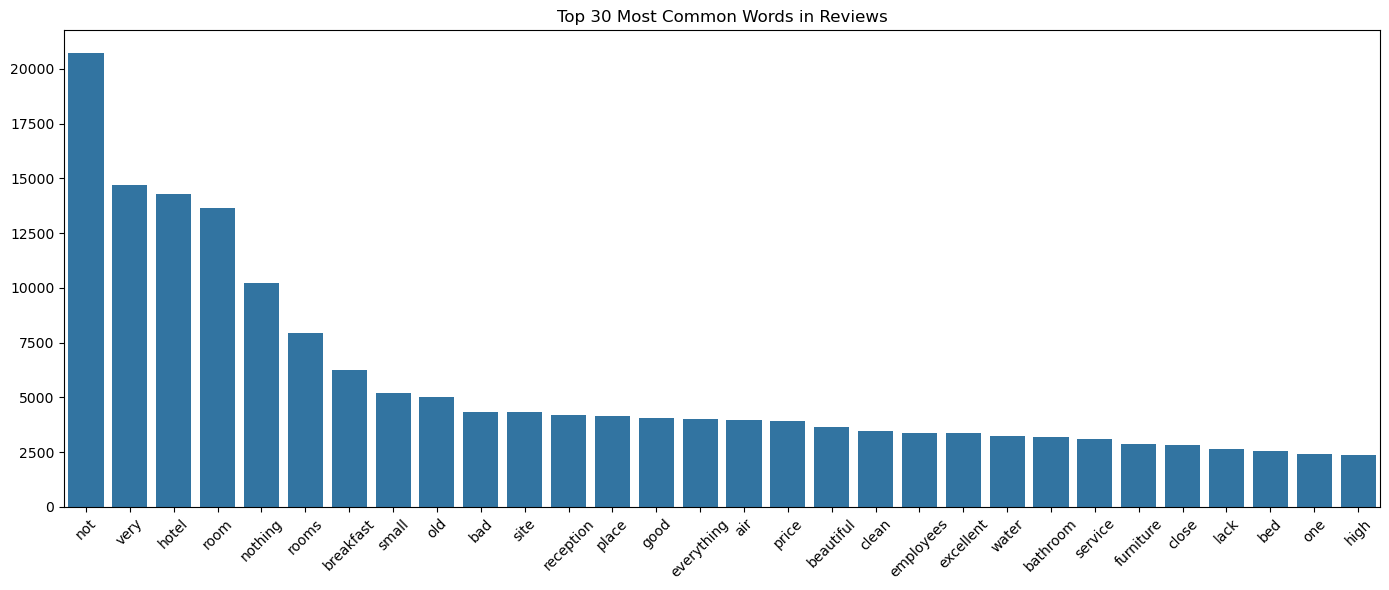

In [17]:
all_tokens = [word for tokens in df['tokens'] for word in tokens]
freq_dist = Counter(all_tokens)

# Plot top 30 words
most_common_words = freq_dist.most_common(30)
words, counts = zip(*most_common_words)

plt.figure(figsize=(14, 6))
sns.barplot(x=list(words), y=list(counts))
plt.title('Top 30 Most Common Words in Reviews')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 8. Review Cleaning - Special Cases
As shown in the previous frequency plot, the word “nothing” appears very frequently across reviews. Upon inspection, we found that some reviews consist solely of this single word, which provides no useful information. In this step, we remove those reviews that contain only the word “nothing”, while preserving those where the word appears as part of a longer, meaningful sentence.

In [18]:
# Filter and show reviews containing the word "nothing"
keyword = "nothing"

# Search in original review
df_with_keyword = df[df['clean_review'].str.contains(rf'\b{keyword}\b', case=False, na=False)]

print(f"Number of reviews containing the word '{keyword}':", df_with_keyword.shape[0])
df_with_keyword[['clean_review']].head(15)

Number of reviews containing the word 'nothing': 10212


,clean_review
27,nothing
30,nothing
40,nothing
41,nothing
42,nothing
44,nothing
46,nothing
49,nothing
53,nothing
60,nothing


In [19]:
# Remove rows where review text is exactly "nothing" (mantain the ones with more text)
df = df[~df['clean_review'].str.strip().str.lower().eq("nothing")]

print("New shape of the DataFrame:", df.shape)

New shape of the DataFrame: (62042, 7)


### 9. Word Cloud and Review Length

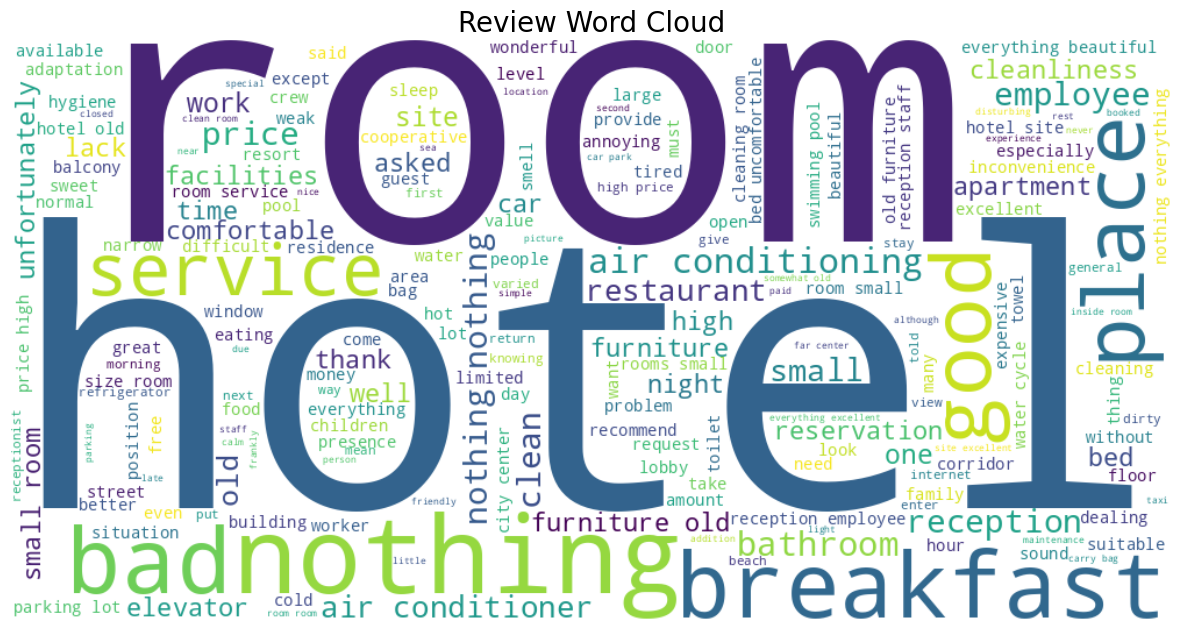

In [ ]:
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(" ".join(all_tokens))
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Review Word Cloud", fontsize=20)
plt.show()

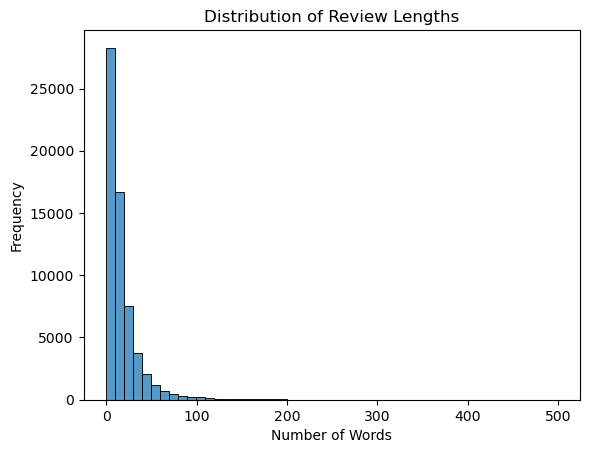

In [ ]:
# Store the number of words in each cleaned review
df['review_len'] = df['clean_review'].apply(lambda x: len(x.split()))
sns.histplot(df['review_len'], bins=50)
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

### 10. Lemmatization
Lemmatization reduces words to their base or dictionary form (e.g., “running” becomes “run”), helping to unify different word forms that carry the same meaning. This step improves the quality of the text representation by minimizing redundancy and enhancing semantic consistency.

In [22]:
nlp = spacy.load('en_core_web_sm')

# Takes a list of tokens and returns their lemmatized forms
def lemmatize_tokens(tokens):
    doc = nlp(' '.join(tokens))
    return [token.lemma_ for token in doc if token.lemma_ != '-PRON-']

df['lemmatized'] = df['tokens'].apply(lemmatize_tokens)

In [23]:
df['joined_lemmas'] = df['lemmatized'].apply(lambda tokens: ' '.join(tokens))

In [24]:
df.iloc[:, 5:].head()

,clean_review,tokens,review_len,lemmatized,joined_lemmas
0,services are far away,"[services, far, away]",4,"[service, far, away]",service far away
1,the air conditioner did not fit,"[air, conditioner, not, fit]",6,"[air, conditioner, not, fit]",air conditioner not fit
2,the breakfast was limited and not hot\r\nalso ...,"[breakfast, limited, not, hot, also, distance,...",44,"[breakfast, limit, not, hot, also, distance, t...",breakfast limit not hot also distance tourist ...
3,the employees deal with bad i requested wate...,"[employees, deal, bad, requested, water, bottl...",43,"[employee, deal, bad, request, water, bottle, ...",employee deal bad request water bottle tell pr...
4,breakfast was not expected,"[breakfast, not, expected]",4,"[breakfast, not, expect]",breakfast not expect


## Analyzing vectorization schemes
Having done a deep preprocessing and analysis; as well as vectorization, lemmatization and joined lematization, we start preparing different Vectorization schemes

### 11. Classical Vectorization - BoW and TF-IDF
To convert the cleaned and lemmatized text into numerical form, we apply two classical vectorization techniques: 
- Bag-of-Words (BoW) to capture word occurrence.
- Term Frequency–Inverse Document Frequency (TF-IDF) - to adjust for word importance across the corpus.

In [25]:
# Bag of Words
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(df["joined_lemmas"])

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df["joined_lemmas"])

In [26]:
# Get the list of all words from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Returns the top N words with the highest TF-IDF score in a document
def get_top_n_words(row, n=5):
    row_data = row.toarray().flatten()
    top_n_ids = row_data.argsort()[-n:][::-1]
    return [(feature_names[i], float(row_data[i])) for i in top_n_ids]

# Example: analyze one review
print(get_top_n_words(X_tfidf[2], n=5))

[('overall', 0.34709850611866183), ('soft', 0.31148730127419544), ('respectable', 0.2847691864049748), ('average', 0.2801630410485502), ('distance', 0.2481598224290555)]


In [27]:
print("TF-IDF sparsity: {:.2f}%".format(100 * (1.0 - X_tfidf.nnz / np.prod(X_tfidf.shape))))

TF-IDF sparsity: 99.95%


The TF-IDF matrix has a very high sparsity (99.95%), which means:
- Most words in the vocabulary appear in very few documents.
- Each document uses only a small subset of the total vocabulary.

This is expected in natural language data and highlights the importance of dimensionality reduction or alternative embeddings.

### 12. GloVe Embeddings
To capture the semantic meaning of words, we use pre-trained GloVe embeddings, which map words to dense vectors based on their global co-occurrence statistics. For each review, we compute an average of the embeddings of its lemmatized words. This produces a compact and informative vector representation that captures word meaning and context beyond simple frequency.

In [30]:
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # Remove leading/trailing whitespace and split the line into parts
            parts = line.strip().split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)
            # Store the word and its vector in the dictionary
            embeddings[word] = vector
    return embeddings

# Path to the GloVe file
glove_file = file_path + '/glove.6B.100d.txt'
# Load GloVe embeddings into the dictionary
glove_embeddings = load_glove_embeddings(glove_file)

In [31]:
# Compute the average GloVe embedding for a list of tokens
def get_average_embedding(tokens, embeddings, dim=100):
    # Extract embeddings only for the words that exist in the provided GloVe dictionary
    valid_vectors = [embeddings[word] for word in tokens if word in embeddings]
    # If at least one word has a valid embedding, return the average vector
    if valid_vectors:
        return np.mean(valid_vectors, axis=0)
    # If none of the tokens are in GloVe, return a zero vector of the specified dimension
    else:
        return np.zeros(dim)

df['glove_vector'] = df['lemmatized'].apply(lambda x: get_average_embedding(x, glove_embeddings))

<Axes: xlabel='embedding_coverage', ylabel='Count'>

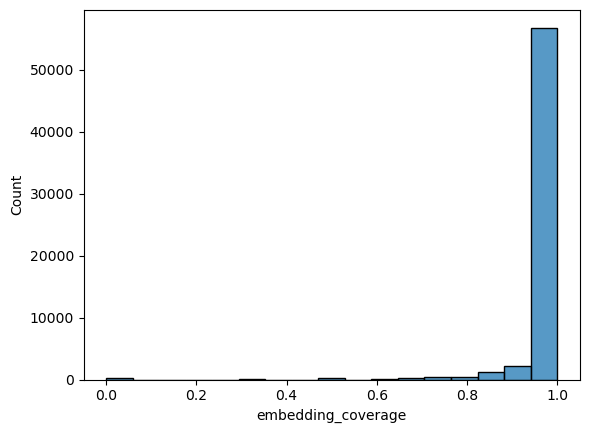

In [32]:
df['embedding_coverage'] = df['lemmatized'].apply(
    lambda tokens: sum(1 for token in tokens if token in glove_embeddings) / len(tokens) if len(tokens) > 0 else 0
)

sns.histplot(df['embedding_coverage'])

- Most reviews have high coverage: A large spike around 1.0 indicates that the majority of reviews are almost fully covered by GloVe embeddings. This is a positive sign, as it suggests that the vocabulary used in the reviews is well represented in the GloVe model.
- Few reviews have low or zero coverage: Small bars near 0 and 0.2 show that some reviews lack sufficient valid embeddings. These reviews may be noisy, extremely short, or contain rare or non-English words.

In [33]:
low_cov = df[df['embedding_coverage'] < 0.5][['clean_review', 'lemmatized', 'embedding_coverage']]
print('Number of reviews with poor coverage:', low_cov.shape[0])
display(low_cov.head())

Number of reviews with poor coverage: 265


,clean_review,lemmatized,embedding_coverage
205,there,[],0.000000
664,,[],0.000000
702,frukosten,[frukosten],0.000000
776,reception especially the employee arkan\r\nnot...,"[reception, especially, employee, arkan, not, ...",0.482759
959,laog,[laog],0.000000


Reviews with poor coverage tend to have unreliable or uninformative embeddings. Keeping such reviews would introduce semantic noise and could negatively impact the generalization of models. Therefore, they are filtered out.

In [34]:
# Filter them out before training models
df = df[df['embedding_coverage'] >= 0.5].reset_index(drop=True)

### 13. Topic Modeling with LDA
To uncover hidden themes in the reviews, we apply Latent Dirichlet Allocation (LDA), a generative probabilistic model that identifies latent topics based on word co-occurrence patterns. Each review is represented as a distribution over these topics, providing a high-level semantic understanding of the text corpus. This can reveal recurring themes.

In [35]:
# Create dictionary and corpus
dictionary = corpora.Dictionary(df["lemmatized"])
corpus = [dictionary.doc2bow(text) for text in df["lemmatized"]]

# Train LDA model
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

# Assign topic distributions to each document
def get_topic_distribution(bow, model, num_topics):
    # Start with a list of zeros for all topics
    dist = [0] * num_topics
    # Fill in the topic probabilities from the model output
    for topic_id, prob in model.get_document_topics(bow):
        dist[topic_id] = prob
    return dist

df["lda_vector"] = [get_topic_distribution(doc, lda_model, num_topics=5) for doc in corpus]

In [36]:
lda_model.print_topics()

[(0,
  '0.063*"old" + 0.050*"air" + 0.047*"need" + 0.043*"hotel" + 0.036*"furniture" + 0.034*"not" + 0.027*"car" + 0.024*"conditioning" + 0.020*"conditioner" + 0.019*"parking"'),
 (1,
  '0.082*"employee" + 0.062*"reception" + 0.036*"very" + 0.025*"deal" + 0.022*"thank" + 0.021*"hotel" + 0.021*"not" + 0.020*"staff" + 0.019*"like" + 0.018*"nothing"'),
 (2,
  '0.131*"room" + 0.062*"very" + 0.045*"small" + 0.036*"price" + 0.034*"not" + 0.034*"bathroom" + 0.028*"clean" + 0.025*"bed" + 0.024*"bad" + 0.020*"high"'),
 (3,
  '0.064*"not" + 0.037*"room" + 0.024*"hotel" + 0.013*"day" + 0.012*"time" + 0.011*"water" + 0.010*"two" + 0.010*"night" + 0.010*"one" + 0.009*"ask"'),
 (4,
  '0.054*"breakfast" + 0.053*"hotel" + 0.038*"very" + 0.038*"site" + 0.035*"place" + 0.035*"everything" + 0.031*"beautiful" + 0.028*"excellent" + 0.028*"good" + 0.028*"close"')]

To validate that the chosen number of topics (in this case, 5) was appropriate, we computed coherence scores across different topic counts and visualized the results. The coherence score measures how semantically interpretable the topics are. By plotting coherence against the number of topics, we confirmed that selecting 5 topics provides a good balance between interpretability and model complexity.

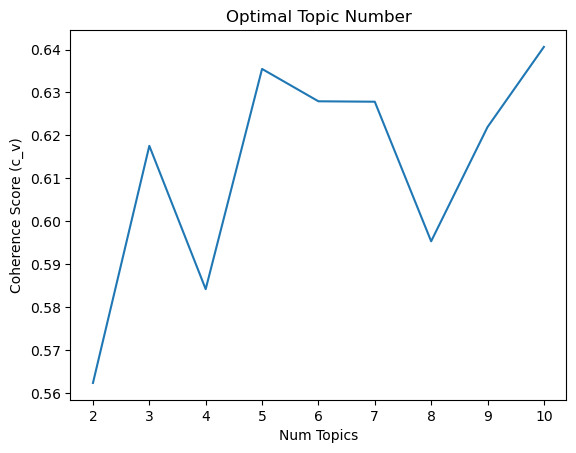

In [38]:
coherences = []
for n in range(2, 11):
    model = models.LdaModel(corpus, num_topics=n, id2word=dictionary, passes=10)
    coherence = CoherenceModel(model=model, texts=df['lemmatized'], dictionary=dictionary, coherence='c_v').get_coherence()
    coherences.append((n, coherence))

# Plot
x, y = zip(*coherences)
plt.plot(x, y)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("Optimal Topic Number")
plt.show()

To better interpret and explore the discovered topics, we use an interactive LDA visualization. This plot helps visualize the relationships between topics, their relative prevalence, and the most relevant terms within each topic. It is a powerful tool for understanding topic separation and coherence, making it easier to assess the quality and interpretability of the topic model.

In [40]:
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)

# Display in notebook (if using Jupyter)
pyLDAvis.display(lda_vis)

In [ ]:
# Save the LDA visualization
pyLDAvis.save_html(lda_vis, 'lda_model.html')
with open("lda_model.pkl", "wb") as f:
    pickle.dump(lda_vis, f)

### 14. Save Final Processed Data

In [43]:
df

,Name,Review,Rating,AvgRating,Country,clean_review,tokens,review_len,lemmatized,joined_lemmas,glove_vector,embedding_coverage,lda_vector
0,The Hera Premium Hotels,Services are far away,5.0,5.7,Türkiye,services are far away,"[services, far, away]",4,"[service, far, away]",service far away,"[-0.21656667, 0.14481267, 0.37502337, -0.26881...",1.0,"[0.050000664, 0.05043597, 0.050537925, 0.05008..."
1,The Hera Premium Hotels,The air conditioner did not fit,7.0,5.7,Türkiye,the air conditioner did not fit,"[air, conditioner, not, fit]",6,"[air, conditioner, not, fit]",air conditioner not fit,"[-0.54576, -0.020142496, 0.3254875, -0.416075,...",1.0,"[0.5794834, 0.040197104, 0.2988736, 0.04129745..."
2,The Hera Premium Hotels,-The breakfast was limited and not hot\r\nAlso...,7.0,5.7,Türkiye,the breakfast was limited and not hot\r\nalso ...,"[breakfast, limited, not, hot, also, distance,...",44,"[breakfast, limit, not, hot, also, distance, t...",breakfast limit not hot also distance tourist ...,"[-0.19023825, 0.116969995, 0.20538403, 0.14445...",1.0,"[0.08049821, 0.07227779, 0.19514716, 0, 0.6427..."
3,The Hera Premium Hotels,The employees deal with bad: 1/ I requested 5 ...,5.0,5.7,Türkiye,the employees deal with bad i requested wate...,"[employees, deal, bad, requested, water, bottl...",43,"[employee, deal, bad, request, water, bottle, ...",employee deal bad request water bottle tell pr...,"[0.06610478, 0.21135677, 0.29462767, -0.131576...",1.0,"[0, 0.24515228, 0, 0.7283458, 0]"
4,The Hera Premium Hotels,Breakfast was not expected,7.0,5.7,Türkiye,breakfast was not expected,"[breakfast, not, expected]",4,"[breakfast, not, expect]",breakfast not expect,"[-0.38929334, 0.22762334, 0.167126, -0.1775379...",1.0,"[0.051142175, 0.05066711, 0.05134363, 0.053181..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61772,Azdan Doha Hotel,Maintenance where frequent problems and also c...,7.0,7.4,Qatar,maintenance where frequent problems and also c...,"[maintenance, frequent, problems, also, contac...",10,"[maintenance, frequent, problem, also, contact...",maintenance frequent problem also contact room...,"[-0.4296979, 0.0520645, 0.06367649, -0.1097614...",1.0,"[0.3278229, 0.022484235, 0.3476949, 0.27938774..."
61773,Azdan Doha Hotel,Parking / breakfast does not have a diversific...,8.0,7.4,Qatar,parking breakfast does not have a diversifica...,"[parking, breakfast, not, diversification, eve...",15,"[parking, breakfast, not, diversification, eve...",parking breakfast not diversification every da...,"[-0.29695627, 0.20628625, 0.11352475, -0.06147...",1.0,"[0.17552988, 0.022288192, 0.022294994, 0.38881..."
61774,Pose Saint Moritz Hotel,The bathroom is very narrow,7.0,7.6,Switzerland,the bathroom is very narrow,"[bathroom, very, narrow]",5,"[bathroom, very, narrow]",bathroom very narrow,"[-0.39736667, 0.40664998, 0.08216999, 0.119161...",1.0,"[0.05009534, 0.050291203, 0.7993099, 0.0500002..."
61775,Radisson Oscar Freire,- Room is old\r\n- bed not comfortable \r\n- y...,6.0,8.2,Brazil,room is old\r\n bed not comfortable \r\n you c...,"[room, old, bed, not, comfortable, hear, noise...",29,"[room, old, bed, not, comfortable, hear, noise...",room old bed not comfortable hear noise neighb...,"[-0.2776956, 0.19966723, 0.37836653, -0.207272...",1.0,"[0.06693754, 0.14508261, 0.10485248, 0.5292183..."


In [44]:
df.to_excel('./BookingReviews_Task1.xlsx', index=False, sheet_name='Reviews')